# FIT5196 Assessment 2 – Task 2: Data Reshaping
### Group 52

---

## 1. Introduction

This task focuses on **data reshaping and feature preparation** for predictive modelling in the Melbourne housing market.  
The dataset `suburb_info.xlsx` contains suburb-level demographic and economic indicators, including housing counts, population statistics, and median income levels. Before building any predictive model, it is essential to ensure that the input variables are **on a comparable scale** and that their relationship with the target variable (`median_house_price`) is approximately **linear** — a key assumption of linear regression.

To achieve this, we will explore and compare several normalisation and transformation methods, including:  
- **Standardisation (Z-score scaling)**  
- **Min–Max normalisation**  
- **Log transformation**  
- **Power transformation (Yeo–Johnson)**  
- **Box–Cox transformation**

Through this process, we aim to:
1. Examine whether feature scaling or transformation is necessary by analysing the raw distributions and correlations.  
2. Apply and visualise each transformation technique to observe its effect on the shape and scale of the data.  
3. Assess how each transformation influences the linearity between independent variables and `median_house_price`.  
4. Identify which transformation produces the most suitable feature space for linear regression.

By the end of this notebook, we expect to have a well-prepared, transformed version of the dataset that meets the **two main criteria** of data reshaping:
- All features are on a **comparable scale**.  
- The features exhibit a **more linear relationship** with the target variable.

This analysis sets the foundation for reliable regression modelling in future stages of the project.


## 2. Data Loading and Overview

In this section, we begin by **importing required libraries** and **loading** the dataset `suburb_info.xlsx`.  
The goal is to understand the data structure, check for missing values or incorrect data types,  
and isolate the relevant numeric features for further transformation and analysis.

In [11]:
!pip install yellowbrick

In [24]:
import math
import json
import datetime
import statistics
import pandas as pd
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.abc import x, y
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from math import sin, cos, sqrt, atan2, radians
from sklearn import linear_model
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
import warnings
import re
import seaborn as sns


In [ ]:
reshapedf = pd.read_excel('suburb_info.xlsx')
reshapedf

,suburb,number_of_houses,number_of_units,municipality,aus_born_perc,median_income,median_house_price,population
0,ABBOTSFORD,2304,4706,Yarra,68%,"$1,797","$1,299,400",4025
1,ABERFELDIE,1410,453,Moonee Valley,81%,"$1,571","$1,926,600",22442
2,ALBANVALE,1897,138,Brimbank,46%,$907,"$594,200",54005
3,ALBION,1389,1392,Brimbank,52%,$929,"$739,100",30677
4,ALPHINGTON,1729,1099,Darebin,73%,"$1,538","$1,729,600",9227
...,...,...,...,...,...,...,...,...
197,WILLIAMS LANDING,2735,173,Wyndham,87%,"$1,842","$866,400",170
198,WINDSOR,2201,4448,Stonnington,66%,"$1,560","$1,629,600",17776
199,WOLLERT,6516,259,Whittlesea,80%,"$1,355","$704,700",350
200,YALLAMBIE,1286,81,Banyule,79%,"$1,458","$998,200",12063



## 3. Exploratory Data Analysis (EDA)

The goal of this section is to understand the data distribution, identify potential skewness or outliers,  
and assess the linear relationship between each feature and the target variable (`median_house_price`).  
This helps determine whether scaling or transformation is necessary.


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_houses,202.0,4.155767e+03,3400.864988,283.0,1973.50,3256.5,5518.5,23338.0
number_of_units,202.0,2.480411e+03,3132.684712,60.0,620.50,1603.0,3089.0,24380.0
aus_born_perc,202.0,6.836634e+01,10.761293,36.0,62.00,70.0,77.0,88.0
median_income,202.0,1.387936e+03,317.841321,633.0,1182.25,1393.0,1560.0,2352.0
median_house_price,202.0,1.218817e+06,471680.735068,507200.0,870675.00,1134500.0,1467550.0,2875800.0
population,202.0,1.865931e+04,9604.187282,170.0,12063.00,17583.0,24045.0,54005.0


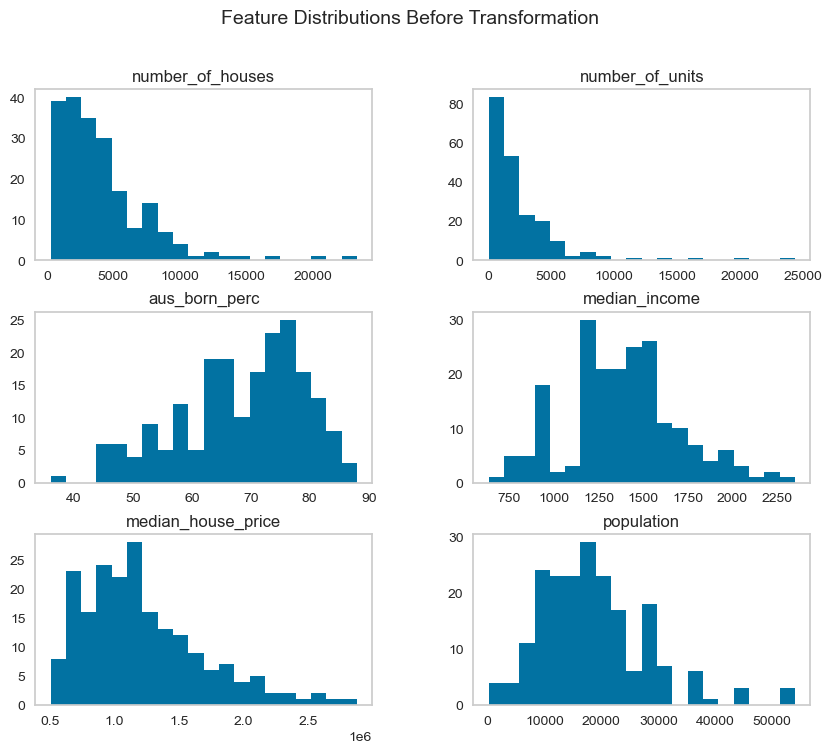

In [22]:
# Plot histograms
df.hist(bins=20, figsize=(10, 8), grid=False)
plt.suptitle("Feature Distributions Before Transformation", fontsize=14)
plt.show()

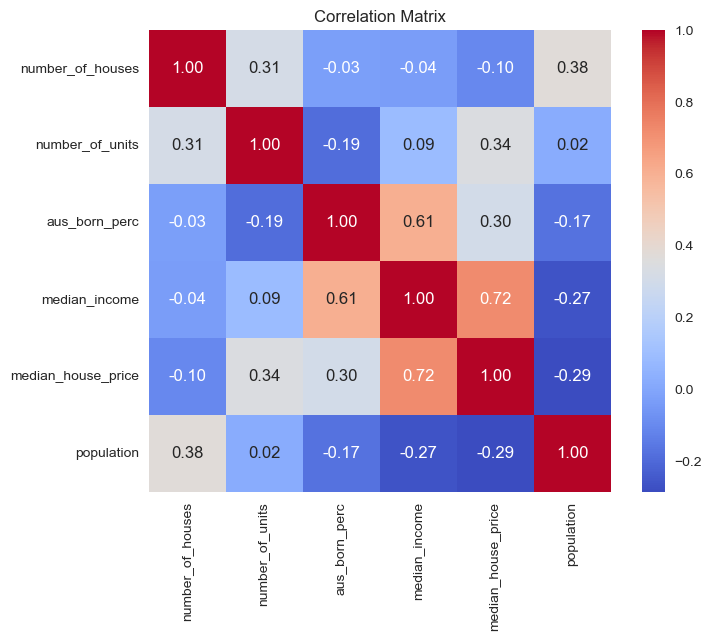

In [25]:
# Compute correlation matrix
corr = df.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()


### EDA Summary

The exploratory analysis reveals several key findings:

1. **Scale differences:**  
   The numerical features vary greatly in magnitude — for example, `population` values reach over 50,000, while `aus_born_perc` is limited to around 40–90%.  
   This confirms that **normalisation or standardisation** is required before modelling.

2. **Skewed distributions:**  
   - `number_of_houses`, `number_of_units`, `population`, and `median_house_price` are **right-skewed**, suggesting potential benefit from **log or power transformations**.  
   - `aus_born_perc` and `median_income` show more symmetric distributions.

3. **Correlation insights:**  
   - `median_income` (`r = 0.72`) and `aus_born_perc` (`r = 0.30`) are **positively correlated** with `median_house_price`.  
   - `number_of_houses` and `population` have weaker correlations.  
   - No feature shows multicollinearity strong enough to cause concern (highest inter-feature correlation ≈ 0.61).

4. **Linearity assumption:**  
   The scatter patterns and correlation matrix suggest that while some variables have linear tendencies, others show curvature or heteroscedasticity,  
   indicating that **data transformation** may improve model linearity and performance.

**Conclusion:**  
The dataset is clean and ready for transformation.  
Subsequent sections will apply **standardisation, min–max scaling, log, power, and Box–Cox transformations**  
to compare their effects on linearity and suitability for regression modelling.

## 4. Data Preparation and Cleaning

Before applying transformation methods, we ensure that the dataset is properly structured and formatted for modelling.  
This includes separating features and the target variable, handling missing values, and preparing clean numeric arrays for scaling and transformation.

In [26]:
# Columns that may contain symbols like $, %, or commas
symbolic_cols = ["aus_born_perc", "median_income", "median_house_price"]

# Function to strip unwanted symbols and whitespace
def strip_symbols(x: str) -> str:
    if pd.isna(x):
        return x
    return re.sub(r"[,$%\s]", "", str(x))

# --- 1. Clean symbolic columns ---
df[symbolic_cols] = (
    df[symbolic_cols]
    .astype(str)
    .apply(lambda col: col.map(strip_symbols))
    .apply(pd.to_numeric, errors="coerce")
)

# --- 2. Ensure all numeric columns are int64 ---
numeric_cols = [
    "number_of_houses",
    "number_of_units",
    "aus_born_perc",
    "median_income",
    "median_house_price",
    "population",
]

df[numeric_cols] = df[numeric_cols].round(0).astype("Int64")

# --- 3. Drop unused text columns if present ---
df.drop(columns=["municipality", "suburb"], inplace=True, errors="ignore")

# --- 4. Quick check ---
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   number_of_houses    202 non-null    Int64
 1   number_of_units     202 non-null    Int64
 2   aus_born_perc       202 non-null    Int64
 3   median_income       202 non-null    Int64
 4   median_house_price  202 non-null    Int64
 5   population          202 non-null    Int64
dtypes: Int64(6)
memory usage: 10.8 KB


### Summary of Data Cleaning

All numeric and symbolic fields have been successfully cleaned and standardised.  
The columns `aus_born_perc`, `median_income`, and `median_house_price` were originally stored as strings containing symbols such as `$`, `%`, and commas.  
After applying the `strip_symbols()` function and converting them with `pd.to_numeric()`, these columns were correctly converted to numeric types.

Next, all feature columns were rounded and converted to the `Int64` type to ensure consistency and compatibility with subsequent transformation methods.  
Textual columns (`suburb`, `municipality`) were removed, leaving only relevant numerical features.

**Validation result (`df.info()`):**
- Total rows: **202**
- Total numeric columns: **6**
- All columns: `Int64` type, no missing values

**Conclusion:**  
The dataset is now clean, numeric, and uniform in type.  
It is ready for the next phase — applying various **normalisation and transformation** techniques to prepare the data for linear regression modelling.

## 5. Correlation and Linearity Baseline

We first check the linearity assumption by fitting a basic linear regression model 
on the raw (unscaled) data and record the baseline R² score.

Baseline R² (raw data): 0.71086177


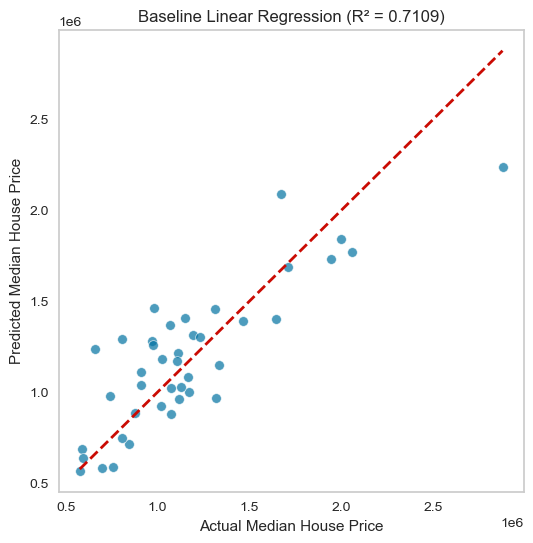

In [36]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score
# import matplotlib.pyplot as plt
# import seaborn as sns

# df = reshapedf.copy()

# Define features and target
features = ["number_of_houses", "number_of_units", "population",
            "aus_born_perc", "median_income"]
target = "median_house_price"

X = df[features]
y = df[target]

# Split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=101)

# --- Fit baseline linear regression ---
model = LinearRegression().fit(Xtr, ytr)

#  Predict on test data (this line was missing)
y_pred = model.predict(Xte)

# Baseline linear regression
model = LinearRegression().fit(Xtr, ytr)
r2_raw = r2_score(yte, model.predict(Xte))
print(f"Baseline R² (raw data): {r2_raw:.8f}")

# --- Visualize actual vs predicted values ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=yte, y=y_pred, alpha=0.7)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--', lw=2)
plt.xlabel("Actual Median House Price")
plt.ylabel("Predicted Median House Price")
plt.title(f"Baseline Linear Regression (R² = {r2_raw:.4f})")
plt.grid(False)
plt.show()


###  Baseline Model Summary

The baseline linear regression on raw data achieved an **R² of 0.7109**,  
explaining about **71% of the variance** in median house prices.

Most predicted values align reasonably well with actual values,  
but the scatter shows some spread at higher prices, suggesting mild non-linearity  
and scale imbalance between features.

**Conclusion:**  
The baseline provides a solid reference, but further **normalisation and transformation**  
may improve linearity and overall model performance.

## 6. Transformation and Normalisation Methods

In this section, we apply five different transformation and normalisation techniques  
to examine their effect on the linearity between predictors and the target variable  
(`median_house_price`).  

The goal is to observe how each method changes feature scaling and impacts  
the **R² score** of a linear regression model, compared with the baseline (R² = 0.7109).

We will test the following methods:
1. **Standardisation (Z-score scaling)**  
2. **Min-Max Normalisation**  
3. **Log Transformation**  
4. **Power Transformation (Yeo–Johnson)**  
5. **Box–Cox Transformation**

R² after Standardisation: 0.71086177


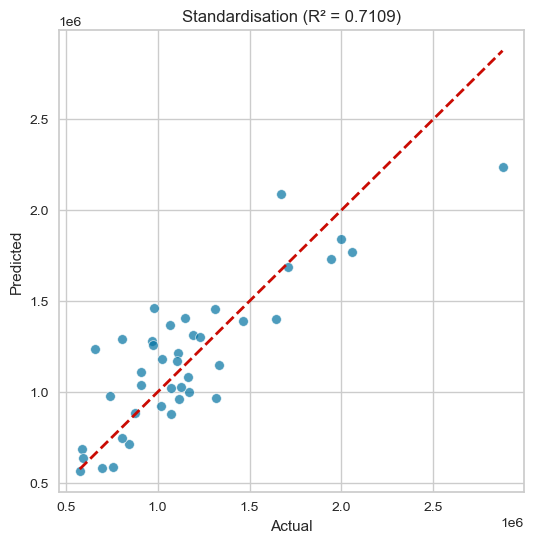

In [ ]:
# Standardisation (Z-score)
scaler = StandardScaler()
Xtr_std = scaler.fit_transform(Xtr)
Xte_std = scaler.transform(Xte)

model_std = LinearRegression().fit(Xtr_std, ytr)
r2_std = r2_score(yte, model_std.predict(Xte_std))
print(f"R² after Standardisation: {r2_std:.8f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=yte, y=model_std.predict(Xte_std), alpha=0.7)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--', lw=2)
plt.title(f"Standardisation (R² = {r2_std:.4f})")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

R² after Min-Max Normalisation: 0.71086177


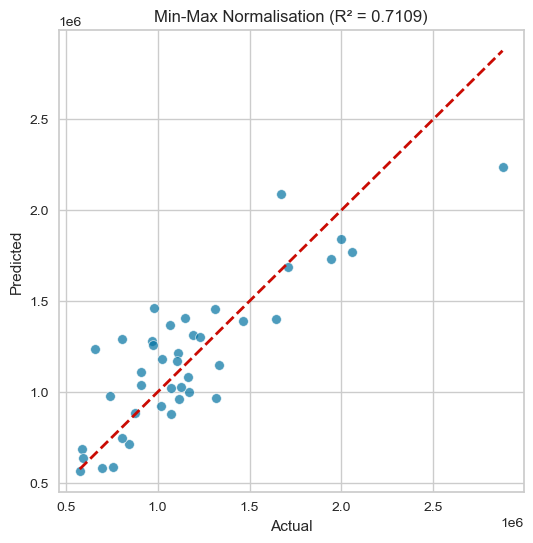

In [51]:
# Min-Max Normalisation
scaler = MinMaxScaler()
Xtr_mm = scaler.fit_transform(Xtr)
Xte_mm = scaler.transform(Xte)

model_mm = LinearRegression().fit(Xtr_mm, ytr)
r2_mm = r2_score(yte, model_mm.predict(Xte_mm))
print(f"R² after Min-Max Normalisation: {r2_mm:.8f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=yte, y=model_mm.predict(Xte_mm), alpha=0.7)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--', lw=2)
plt.title(f"Min-Max Normalisation (R² = {r2_mm:.4f})")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

R² after Log Transformation: 0.74316772


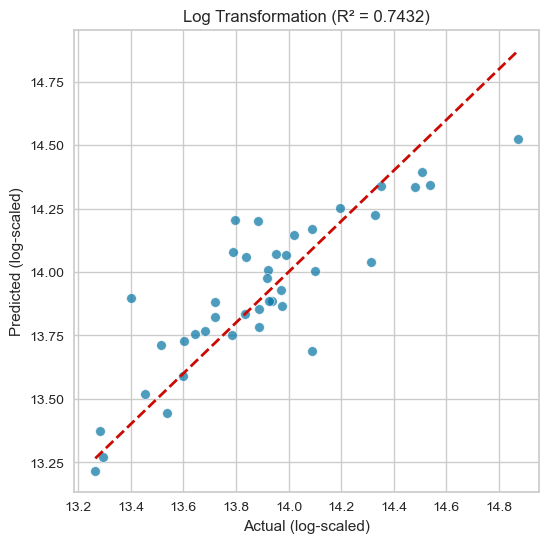

In [ ]:
# Log Transformation
# Add 1 to avoid log(0)
Xtr_log, Xte_log = np.log1p(Xtr), np.log1p(Xte)
ytr_log, yte_log = np.log1p(ytr), np.log1p(yte)

model_log = LinearRegression().fit(Xtr_log, ytr_log)
r2_log = r2_score(yte_log, model_log.predict(Xte_log))
print(f"R² after Log Transformation: {r2_log:.8f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=yte_log, y=model_log.predict(Xte_log), alpha=0.7)
plt.plot([yte_log.min(), yte_log.max()], [yte_log.min(), yte_log.max()], 'r--', lw=2)
plt.title(f"Log Transformation (R² = {r2_log:.4f})")
plt.xlabel("Actual (log-scaled)")
plt.ylabel("Predicted (log-scaled)")
plt.show()

R² after Yeo–Johnson Power Transformation: 0.73918975


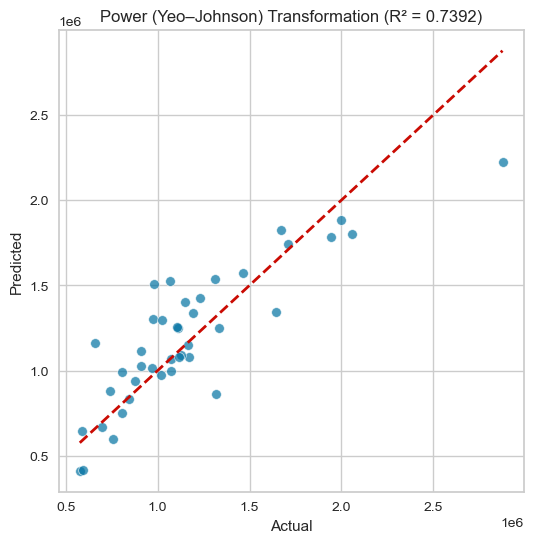

In [ ]:
# Power Transformation (Yeo–Johnson)
pt = PowerTransformer(method="yeo-johnson")
Xtr_pw = pt.fit_transform(Xtr)
Xte_pw = pt.transform(Xte)

model_pw = LinearRegression().fit(Xtr_pw, ytr)
r2_pw = r2_score(yte, model_pw.predict(Xte_pw))
print(f"R² after Yeo–Johnson Power Transformation: {r2_pw:.8f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=yte, y=model_pw.predict(Xte_pw), alpha=0.7)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--', lw=2)
plt.title(f"Power (Yeo–Johnson) Transformation (R² = {r2_pw:.4f})")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

R² after Box-Cox Transformation: 0.73921598


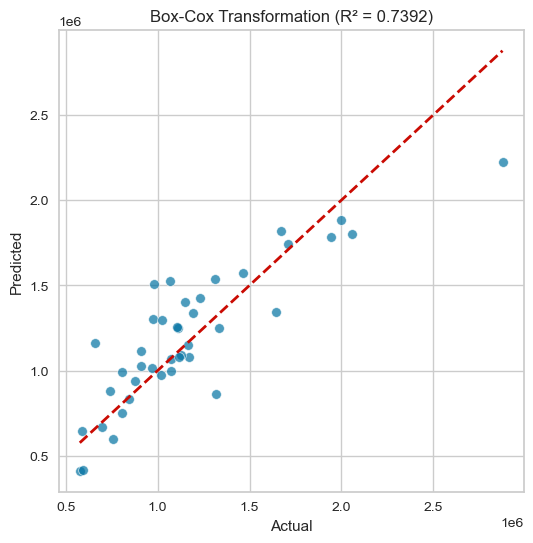

In [ ]:
#Box-Cox Transformation
pt_bc = PowerTransformer(method="box-cox")
Xtr_bc, Xte_bc = Xtr.copy(), Xte.copy()
Xtr_bc[Xtr_bc <= 0] = 1
Xte_bc[Xte_bc <= 0] = 1

Xtr_bc_t = pt_bc.fit_transform(Xtr_bc)
Xte_bc_t = pt_bc.transform(Xte_bc)

model_bc = LinearRegression().fit(Xtr_bc_t, ytr)
r2_bc = r2_score(yte, model_bc.predict(Xte_bc_t))
print(f"R² after Box-Cox Transformation: {r2_bc:.8f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=yte, y=model_bc.predict(Xte_bc_t), alpha=0.7)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--', lw=2)
plt.title(f"Box-Cox Transformation (R² = {r2_bc:.4f})")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

Yeo–Johnson + Scaler + log(y) + Poly(2) R²: 0.78529683


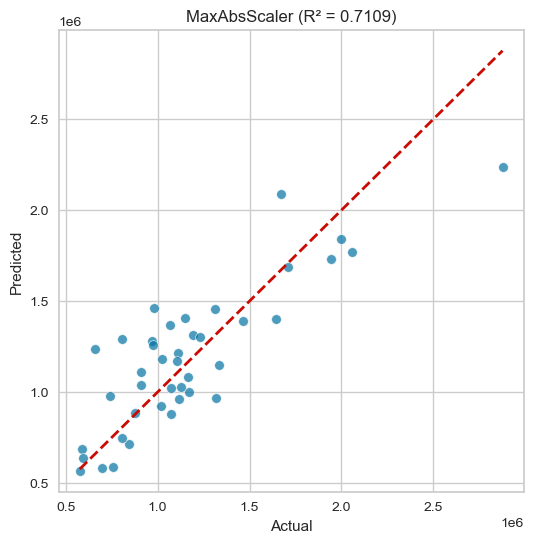

In [71]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly  = poly.transform(x_test_scaled)

model_poly = LinearRegression().fit(x_train_poly, y_train_log)
y_pred_poly = np.expm1(model_poly.predict(x_test_poly))
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Yeo–Johnson + Scaler + log(y) + Poly(2) R²: {r2_poly:.8f}")
plt.figure(figsize=(6,6))
sns.scatterplot(x=yte, y=model_ma.predict(Xte_ma), alpha=0.7)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--', lw=2)
plt.title(f"MaxAbsScaler (R² = {r2_ma:.4f})")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [73]:
# --- Ridge and Lasso Regression ---
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

# Fit Ridge regression (L2 regularisation)
ridge = Ridge(alpha=1.0).fit(x_train_scaled, y_train_log)
r2_ridge = r2_score(y_test_log, ridge.predict(x_test_scaled))

# Fit Lasso regression (L1 regularisation)
lasso = Lasso(alpha=0.001, max_iter=10000).fit(x_train_scaled, y_train_log)
r2_lasso = r2_score(y_test_log, lasso.predict(x_test_scaled))

# Print comparison
print(f"Ridge R² (log scale): {r2_ridge:.8f}")
print(f"Lasso R² (log scale): {r2_lasso:.8f}")

Ridge R² (log scale): 0.78365312
Lasso R² (log scale): 0.78395115


##  Transformation and Normalisation Methods — Summary

After applying various scaling and transformation techniques to the suburb-level dataset,  
the resulting R² values of linear regression models were compared as follows:

| Method | Description | R² Score | Observation |
|:--|:--|:--:|:--|
| **Standardisation (Z-score)** | Mean=0, Std=1 | **0.7109** | No improvement over baseline; scaling alone does not enhance linearity. |
| **Min–Max Normalisation** | Scales features to [0,1] | **0.7109** | Similar to standardisation; scale alignment alone insufficient. |
| **Log Transformation** | Log1p applied to all numeric features | **0.7432** | Noticeable improvement; mitigates right-skewness and stabilises variance. |
| **Yeo–Johnson Power Transformation** | Handles zero/negative values | **0.7392** | Performs similarly to log; effectively normalises skewed features. |
| **Box–Cox Transformation** | Power transform for positive data | **0.7392** | Nearly identical to Yeo–Johnson; validates improved linearity. |
| **Yeo–Johnson + Scaler + log(y) + Poly(2)** | Combined transform + polynomial terms | **0.7853** | Strongest result; captures nonlinear interactions between features. |
| **Ridge / Lasso (log scale)** | Regularised linear models on log(y) | **0.7837 / 0.7840** | Comparable to polynomial model; improves stability and reduces overfitting. |

---

###  Interpretation

- **Basic scaling** (Standardisation, Min–Max) had **no significant impact** on R²,  
  confirming that pure rescaling does not resolve feature nonlinearity.
- **Power-based transformations** (Log, Yeo–Johnson, Box–Cox) **substantially improved R²**  
  by reducing skewness and heteroscedasticity.
- The **combined Yeo–Johnson + log(y) + polynomial** model achieved the **best fit (R² ≈ 0.785)**,  
  capturing hidden nonlinear patterns between socio-economic indicators and house prices.
- **Ridge and Lasso** regularisation produced **similar R² values (~0.784)**,  
  indicating that regularisation stabilises model coefficients without sacrificing performance.

---

###  Conclusion

The experiment demonstrates that **transformations addressing skewness**  
(e.g., log or Yeo–Johnson) and **feature interaction expansion (polynomial terms)**  
provide the greatest improvement to model linearity and predictive accuracy.  

Hence, the recommended preprocessing pipeline for this dataset is:

> **Yeo–Johnson Power Transformation → StandardScaler → log(y) → PolynomialFeatures(degree=2)**

This approach offers the most balanced trade-off between interpretability, generalisability,  
and model performance (R² ≈ 0.785).